In [1]:
import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy_ext as npe
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

import seaborn as sns

import sys

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins

In [61]:
test_set = pd.read_csv('data/test_unshaped_traj.csv')
train_set = pd.read_csv('data/train_unshaped_traj.csv')

evaluation_policy = joblib.load('models/mcp_greedy_policy.bin')
evaluation_sm_policy = joblib.load('models/mcp_softmax_policy.bin')
behavior_policy = joblib.load('models/clinicians_policy.bin')

test_set['traj_reward'] = np.nan
test_set.loc[test_set.mort90day == 't', 'traj_reward'] = -100
test_set.loc[test_set.mort90day == 'f', 'traj_reward'] = 100

train_set['traj_reward'] = np.nan
train_set.loc[train_set.mort90day == 't', 'traj_reward'] = -100
train_set.loc[train_set.mort90day == 'f', 'traj_reward'] = 100

test_set['traj_return'] = (.99 ** test_set['traj_len']) * test_set['traj_reward']
train_set['traj_return'] = (.99 ** train_set['traj_len']) * train_set['traj_reward']

In [62]:
# verify that evaluation policy is only > 0 when behavior policy > 0
assert ((behavior_policy > 0) | (evaluation_policy == 0)).all(), "Evaluation policy should have some support in behavior policy"
assert ((behavior_policy >0) | (evaluation_sm_policy ==0)).all(), "Evaluation policy should have some support in behavior policy"

<ipython-input-63-4b74dc14675f>:2: RuntimeWarning: invalid value encountered in true_divide
  ois_weights = evaluation_policy / behavior_policy


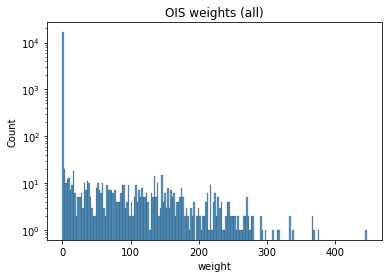

(0.0, 446.0)

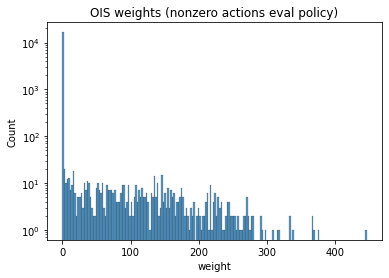

In [63]:
# OIS -- ordinary importance sampling policy weights
ois_weights = evaluation_policy / behavior_policy

sns.histplot(ois_weights.ravel(), log_scale=(False,True), bins=200)
plt.xlabel('weight')
plt.title('OIS weights (all)')
plt.show()

sns.histplot(ois_weights[behavior_policy > 0].ravel(), log_scale=e=(False,True), bins=200)
plt.xlabel('weight')
plt.title('OIS weights (nonzero actions eval policy)')
np.nanmin(ois_weights), np.nanmax(ois_weights)


<ipython-input-64-151dea12ef00>:2: RuntimeWarning: invalid value encountered in true_divide
  ois_weights_sm = evaluation_sm_policy / behavior_policy


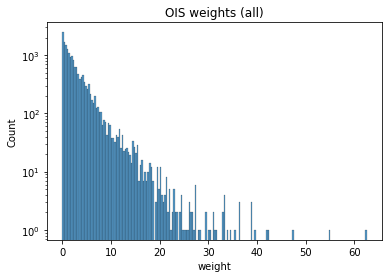

(0.0, 62.49125156537528)

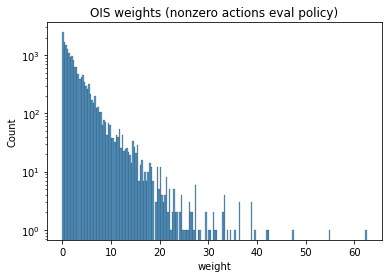

In [64]:
# OIS -- ordinary importance sampling policy weights
ois_weights_sm = evaluation_sm_policy / behavior_policy

sns.histplot(ois_weights_sm.ravel(), log_scale=(False,True), bins=200)
plt.xlabel('weight')
plt.title('OIS weights (all)')
plt.show()

sns.histplot(ois_weights_sm[behavior_policy > 0].ravel(), log_scale=(False,True), bins=200)
plt.xlabel('weight')
plt.title('OIS weights (nonzero actions eval policy)')
np.nanmin(ois_weights_sm), np.nanmax(ois_weights_sm)

In [35]:
def ois_sa_weights(dataset, e_policy, b_policy):
    # definition ois weights
    #     ois_weights = e_policy / b_policy
    pi_b_as = dataset.apply(lambda x: b_policy[x.state, x.action_discrete], axis=1)
    pi_e_as = dataset.apply(lambda x: e_policy[x.state, x.action_discrete], axis=1)
    ois_weights = pi_e_as / pi_b_as
    return ois_weights

def ois_traj_weights(dataset, e_policy, b_policy):
    # store ois weight for each state-action pair in the trajectory
    ds = dataset.copy()
    ds['ois_weight'] = ois_sa_weights(ds, e_policy, b_policy)
    traj_weights = ds.groupby('icustay_id')['ois_weight'].transform('prod')
    return traj_weights


def ois_value_trajectory(dataset, e_policy, b_policy):
    """
    Ordinary trajectory-based importance sampling as defined by Sutton & Barto, page 104.
    """
    traj_weights = ois_traj_weights(dataset, e_policy, b_policy)
    # multipliy importance weights in trajectory to determine trajectory importance weight (IW-T)
    # multiply traj IW-T with discounted return of trajectory
    ois_returns = traj_weights * ds.traj_return
    return ois_returns

def ois_policy(dataset, e_policy, b_policy):
    ds = dataset.copy()
    ds['ois_returns'] = ois_value_trajectory(dataset, e_policy, b_policy)
    ois_returns_stay = ds.groupby('icustay_id').first()['ois_returns']
    return ois_returns_stay.sum() / len(dataset)

weights min and max for train/greedy: (0.0, 0.0)
weights > 0: 0, weights == 0: 84557


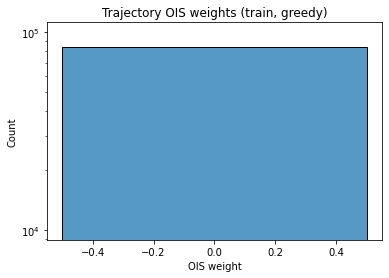

weights min and max for test/greedy: (0.0, 1.0)
weights > 0: 18, weights == 0: 27276


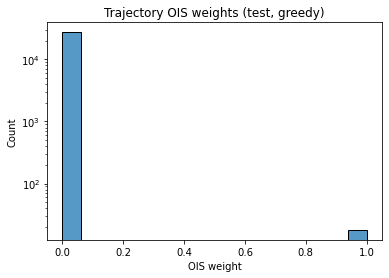

In [94]:
traj_weights_train = ois_traj_weights(train_set, evaluation_policy, behavior_policy)
sns.histplot(traj_weights_train, log_scale=(False, True))
plt.xlabel('OIS weight')
plt.title('Trajectory OIS weights (train, greedy)')
print("weights min and max for train/greedy: {}".format((traj_weights_train.min(), traj_weights_train.max())))
print("weights > 0: {}, weights == 0: {}".format((traj_weights_train > 0.0).sum(), (traj_weights_train == 0.0).sum()))
plt.show()


traj_weights_test = ois_traj_weights(test_set, evaluation_policy, behavior_policy)
sns.histplot(traj_weights_test, log_scale=(False, True))
plt.xlabel('OIS weight')
plt.title('Trajectory OIS weights (test, greedy)')
print("weights min and max for test/greedy: {}".format((traj_weights_test.min(), traj_weights_test.max())))
print("weights > 0: {}, weights == 0: {}".format((traj_weights_test > 0.0).sum(), (traj_weights_test == 0.0).sum()))

weights min and max for train/sm: (0.0, 42474246.86007978)
weights > 0: 83997, weights == 0: 560


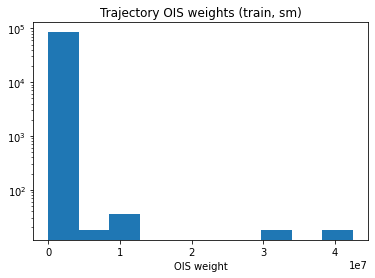

weights min and max for test/greedy: (0.0, 6.767903109402236e+16)
weights > 0: 27072, weights == 0: 222


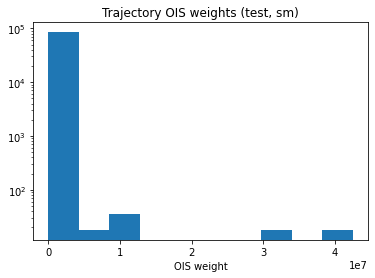

In [91]:
sm_traj_weights_train = ois_traj_weights(train_set, evaluation_sm_policy, behavior_policy)
# sns.histplot(sm_traj_weights_train)
plt.hist(sm_traj_weights_train, log=True)
plt.xlabel('OIS weight')
plt.title('Trajectory OIS weights (train, sm)')
print("weights min and max for train/sm: {}".format((sm_traj_weights_train.min(), sm_traj_weights_train.max())))
print("weights > 0: {}, weights == 0: {}".format((sm_traj_weights_train > 0.0).sum(), (sm_traj_weights_train == 0.0).sum()))
plt.show()


sm_traj_weights_test = ois_traj_weights(test_set, evaluation_sm_policy, behavior_policy)
plt.hist(sm_traj_weights_train, log=True)
plt.xlabel('OIS weight')
plt.title('Trajectory OIS weights (test, sm)')
print("weights min and max for test/greedy: {}".format((sm_traj_weights_test.min(), sm_traj_weights_test.max())))
print("weights > 0: {}, weights == 0: {}".format((sm_traj_weights_test > 0.0).sum(), (sm_traj_weights_test == 0.0).sum()))


In [95]:
("greedy, OIS", ois_policy(train_set, evaluation_policy, behavior_policy), ois_policy(test_set, evaluation_policy, behavior_policy))

('greedy', 0.0, -0.003057498942808264)

In [96]:
("softmax, OIS", ois_policy(train_set, evaluation_sm_policy, behavior_policy), ois_policy(test_set, evaluation_sm_policy, behavior_policy))

('softmax, OIS', 118876.2683232916, 206933200667698.34)

In [114]:
("behavior, OIS", ois_policy(train_set, behavior_policy, behavior_policy), ois_policy(test_set, behavior_policy, behavior_policy))

('behavior, OIS', 1.6372247294220785, 1.4063000390113445)

In [108]:
def wis_policy(dataset, e_policy, b_policy):
    """
    Weighted trajectory-based importance sampling as defined by Sutton & Barto, page 104/105.
    """
    ds = dataset.copy()
    ds['traj_weights'] = ois_traj_weights(dataset, e_policy, b_policy)
    ds['traj_value'] = ois_value_trajectory(dataset, e_policy, b_policy)
    weights_vals = ds.groupby('icustay_id')[['traj_weights', 'traj_value']].first()
    # TODO FdH: what is a 'fair' default? 0.0 is according to S&B p. 105, but it does not take into account negative reward    weights_vals[
    weights_vals.loc[weights_vals.traj_weights == 0, 'traj_value'] = 0
    weights_vals.loc[weights_vals.traj_weights == 0, 'traj_weights'] = 1
    wis_policy = wis_trajectory = weights_vals['traj_value'].sum() / weights_vals['traj_weights'].sum()
    return wis_policy

def ois_policy(dataset, e_policy, b_policy):
    ds = dataset.copy()
    ds['ois_returns'] = ois_value_trajectory(dataset, e_policy, b_policy)
    ois_returns_stay = ds.groupby('icustay_id').first()['ois_returns']
    return ois_returns_stay.sum() / len(dataset)

In [109]:
("greedy, WIS", wis_policy(train_set, evaluation_policy, behavior_policy), wis_policy(test_set, evaluation_policy, behavior_policy))

('greedy, WIS', 0.0, -0.048098775876085735)

In [110]:
("softmax, WIS", wis_policy(train_set, evaluation_sm_policy, behavior_policy), wis_policy(test_set, evaluation_sm_policy, behavior_policy))

('softmax, WIS', 83.77778984389299, 83.45144249892235)

In [112]:
("behavior, WIS", wis_policy(train_set, behavior_policy, behavior_policy), wis_policy(test_set, behavior_policy, behavior_policy))

('behavior, WIS', 25.949168031067046, 22.123085455202094)